In [1]:
import torch
import os
import glob
import pickle

if 'DISPLAY' in os.environ:
    del os.environ['DISPLAY']
    
user_env = os.environ['USER']
job_env = os.environ['SLURM_JOB_ID']
import sys
sys.path.append('../externals/hnn-core')
sys.path.append('../../externals/hnn-core')
sys.path.append('../code')
from tqdm import tqdm
from torch import optim
import numpy as np
import datetime
from pathlib import Path
from utils import (load_prerun_simulations, filter_borders, filter_nzeros, filter_peakproeminence,
                   filter_removeoutliers, filter_peaktime, linear_scale_forward, simulator_hnn,
                   UniformPrior, PriorBetaFiltered, build_flow, hnn_beta_param_function)
from functools import partial
import joblib
from distributed import Client
from dask_jobqueue import SLURMCluster
import dask
from joblib import Parallel, delayed
import datetime
import dask.bag as db
from sbi import inference as sbi_inference
from hnn_core import calcium_model, jones_2009_model
import matplotlib.pyplot as plt
import dill

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [2]:
data_path = '../data'
dpl_orig, theta_orig = np.load(f'{data_path}/sbi_sims/dpl_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)

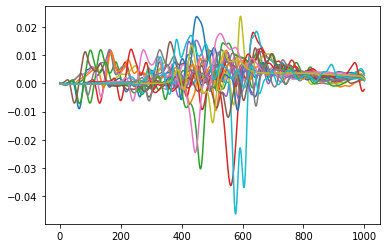

In [3]:
%matplotlib inline
_ = plt.plot(dpl_orig[:20,:].T)

In [4]:
filters = [filter_borders, filter_nzeros, filter_peakproeminence, filter_peaktime, filter_removeoutliers]
# Filter simulations
dpl_filter, theta_filter = dpl_orig, theta_orig
for filter_func in filters:
    dpl_filter, theta_filter = filter_func(dpl_filter, theta_filter)

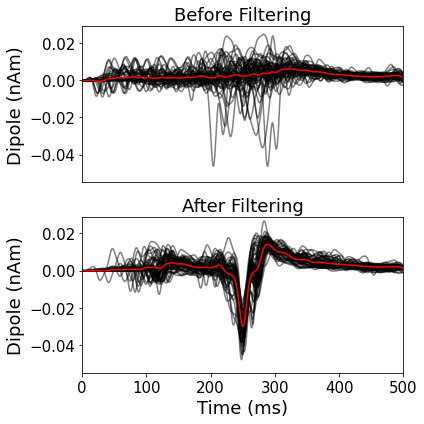

In [32]:
labelsize = 18
titlesize = 18
ticksize = 15
alpha=0.5
ylim = [-0.055, 0.029]
xlim = [0, 500]
xtimes = np.linspace(0, 500, dpl_filter.shape[1])

plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
orig_plot_data = dpl_orig[:50,:]
_ = plt.plot(xtimes, orig_plot_data.T, color='k', alpha=alpha)
plt.plot(xtimes, np.mean(orig_plot_data, axis=0), color='r')
plt.xticks([])
_ = plt.yticks(size=ticksize)
plt.ylabel('Dipole (nAm)', size=labelsize)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('Before Filtering', size=titlesize)


plt.subplot(2,1,2)
filtered_plot_data = dpl_filter[:50,:]
_ = plt.plot(xtimes, filtered_plot_data.T, color='k', alpha=alpha)
plt.plot(xtimes, np.mean(filtered_plot_data, axis=0), color='r')
_ = plt.xticks(size=ticksize)
_ = plt.yticks(size=ticksize)
plt.xlabel('Time (ms)', size=labelsize)
plt.ylabel('Dipole (nAm)', size=labelsize)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('After Filtering', size=titlesize)

plt.tight_layout()
plt.savefig('../figures/beta_filter.svg')

In [8]:
prior_filtered = PriorBetaFiltered(parameters=list(prior_dict.keys()))
optimizer = optim.Adam(prior_filtered.flow.parameters())

num_iter = 5000
for i in tqdm(range(num_iter)):
    optimizer.zero_grad()
    loss = -prior_filtered.flow.log_prob(inputs=theta_filter).mean()
    loss.backward()
    optimizer.step()
state_dict = prior_filtered.flow.state_dict()

100%|██████████| 5000/5000 [00:42<00:00, 116.36it/s]


In [8]:
num_sims = 100_000
theta_samples = prior_filtered.sample((num_sims,))

In [ ]:
df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}

In [ ]:
labelsize=20

param_labels = []

df = scatter_data_list[feature_idx]
theta_cond_transformed_list = theta_data_list[feature_idx]

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
g = sns.PairGrid(df, hue='cond_name', diag_sharey=False, corner=False)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(3):    
    # Add space to visuzalize groundtruth tick marks at top
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])

    g.axes[idx,idx].scatter(theta_cond_transformed_list[0][idx], all_bounds[idx][1] - y_diff*0.1,
                            color='blue', marker='*', s=100)
    g.axes[idx,idx].scatter(theta_cond_transformed_list[1][idx], all_bounds[idx][1] - y_diff*0.1,
                            color='orange', marker='*', s=100)

    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[2,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

for idx1 in range(3):
    for idx2 in range(3):
        if g.axes[idx1, idx2] != None:
            g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
plt.suptitle(input_type_list[feature_idx])